In [1]:
import pandas as pd
import string
import numpy as np
from collections import Counter
import math
from scipy.stats import f_oneway, kruskal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scikit_posthocs as sp
from scipy.stats import spearmanr, kendalltau, pearsonr
import itertools
from scipy.spatial.distance import jensenshannon
from statsmodels.stats import inter_rater as irr

# Why Context Matters: Exploring How Musical Context Impacts User Behavior, Mood, and Musical Preferences

Music consumption is shaped by both internal factors (e.g., mood, motivation) and external factors (e.g., activity, social environment), which together influence listeners’ behavior (e.g., focus, songs’ skips) and reactions (e.g., mood changes). While prior research has explored real-life or survey-based, context-aware music listening with limited available context information, we introduce a dataset
comprising 216 music listening sessions collected in real-world settings through a custom-built Android mobile application designed to assess a wide range of contextual factors. The dataset captures
static (e.g., activity, social environment, motivation) and dynamic (e.g., mood changes) contextual factors, along with music interaction data (e.g., skipped or fully listened songs), listening focus
levels, and participant traits (e.g., demographics, music education, listening preferences, personality).
Our analysis highlights key insights into how different contextual factors influence user behavior and mood. demonstrating signif-
icant differences in skipping songs, focus levels, and genre diversity. We show that music listening sessions grouped by context are significantly different in terms of music listening behaviors (focus,
skipping, and session genre diversity) and mood changes (happiness, sadness, stress, and energy). Furthermore, we explore the correlations between personality traits and listening behaviors (mean skip rate and genre diversity). Ultimately, our findings emphasize the importance of understanding context, as different situations lead to distinct music preferences and have varying impacts on user
behavior and emotional responses. 

## Load data

In [2]:
df_session = pd.read_json("processed/id_session.json")
df_tracks = pd.read_json("processed/id_tracks.json")

In [3]:
df_session['len_listened_songs'].max()

166

In [4]:
def is_valid(row):
    return len(row) == 2 and "-1" not in row

def is_valid_text(row):
    return row is not None and len(row) > 0

def has_max_25_songs(row):
    return 1 <= len(row) <= 100
    

df_valid = (df_session[(df_session['state_ids'].apply(is_valid)) & (df_session['activity'].apply(is_valid_text))& (df_session['social'].apply(is_valid_text)) & (df_session['listened_songs'].apply(has_max_25_songs))])
len(df_valid), df_valid.head()

(216,
                          id                           time_start  \
 2  63bd601bdb31284e0e3fb3b9    Tuesday, 10 January 2023 13:54:49   
 3  63bed71b53db5bfdbc56a154  Wednesday, 11 January 2023 16:34:48   
 4  63c3c931f43b1dfc456b0c1c     Sunday, 15 January 2023 10:36:45   
 5  63c3f98c2037a319fefef0e7     Sunday, 15 January 2023 14:03:04   
 7  63c67bead0942c999756411f    Dienstag, 17 Jänner 2023 11:43:50   
 
                               time_end                   user_id  \
 2    Tuesday, 10 January 2023 14:46:23  63a348bb40416273f5bd4762   
 3  Wednesday, 11 January 2023 16:51:51  63a348bb40416273f5bd4762   
 4     Sunday, 15 January 2023 11:38:57  63a348bb40416273f5bd4762   
 5     Sunday, 15 January 2023 14:23:30  63a348bb40416273f5bd4762   
 7    Dienstag, 17 Jänner 2023 12:08:27  63c67b9bd0809c29d4c80b25   
 
                                            state_ids  \
 2  [63bd601c8a81cf6bdf04979b, 63bd6c305ef1a5ac9ea...   
 3  [63bed71ddf7b4a7f3a473a1d, 63bedb175ef1a5ac9

## Genre of Songs

In [5]:
df_tracks.head()

,id,name,artist,album,mbid,url,tags,music4all_id,spotify_url,youtube_url,artist_tags
3,2,I Will Survive - Single Version,Gloria Gaynor,Millennium Edition,405820a6-f8f7-34d6-8ec3-215f25a7c81c,https://www.last.fm/music/Gloria+Gaynor/_/I+Wi...,"[[silkred-BigFraserFunk, 100], [Disco, 50], [s...",1HJwHtefKWOKO7Fo,https://open.spotify.com/track/07zjHn4pg8bsUJm...,https://www.youtube.com/watch?v=FHhZPp08s74,"[[Disco, 100], [70s, 57], [female vocalists, 5..."
4,3,Electric Love,BØRNS,Dopamine,d8efa4bc-05a6-4d12-b08f-100eda396789,https://www.last.fm/music/B%C3%98RNS/_/Electri...,"[[indie, 100], [alternative rock, 100], [elect...",None,https://open.spotify.com/track/2GiJYvgVaD2HtM8...,https://www.youtube.com/watch?v=RYr96YYEaZY,"[[pop, 100], [seen live, 95], [indie pop, 78],..."
5,4,Ribs,Lorde,Pure Heroine (Extended),0262883c-af38-47d5-83cb-7b2c0839c250,https://www.last.fm/music/Lorde/_/Ribs,"[[pop, 100], [synthpop, 100], [electronic, 79]...",IiKMWlJ4N1MvBpHc,https://open.spotify.com/track/0TEekvXTomKt3hd...,https://www.youtube.com/watch?v=b7pE8AG1jjE,"[[pop, 100], [indie pop, 92], [electronic, 77]..."
6,5,Are You Bored Yet? (feat. Clairo),Wallows,Nothing Happens,,https://www.last.fm/music/Wallows/_/Are+You+Bo...,"[[indie, 100], [alternative, 100], [indie pop,...",None,https://open.spotify.com/track/1ddTXUyQS98p4R2...,https://www.youtube.com/watch?v=wIgmyE5Juzw,"[[indie, 100], [indie rock, 88], [seen live, 8..."
7,6,Tongue Tied,Grouplove,Never Trust a Happy Song,22896076-c971-4439-ac91-48ab4bdf3d98,https://www.last.fm/music/Grouplove/_/Tongue+Tied,"[[indie, 100], [indie rock, 60], [indie pop, 5...",nfVNJlHreFIa7gZN,https://open.spotify.com/track/14eXIZzlnw956Tc...,https://www.youtube.com/watch?v=1x1wjGKHjBI,"[[indie, 100], [indie rock, 85], [indie pop, 7..."


In [6]:
text = """
genre/subgenre  recordings  releasegroups
blues   15703   4231
blues---acousticblues   203 100
blues---chicagoblues    1295    409
blues---classicblues    2110    753
blues---countryblues    746 275
blues---deltablues  1757    499
blues---electricblues   1050    561
blues---jazzblues   454 291
blues---modernblues 506 296
brazilian   2504    861
brazilian---mpb 1530    520
brazilian---samba   668 311
chillout    7517    3705
christian   1985    677
christian---christianrock   1211    383
christian---contemporarychristian   726 265
christmas/holiday   3597    1253
christmas/holiday---holiday 1378    568
classical   7058    2329
classical---baroque 650 282
classical---contemporaryclassical   1802    689
classical---opera   680 325
classical---symphony    689 289
country 20646   5357
country---alternativecountry    3336    1216
country---americana 3928    1515
country---bluegrass 1713    546
country---classiccountry    4610    1728
country---countryfolk   230 151
country---countrypop    919 427
country---countryrock   1335    743
country---honkytonk 653 318
country---linedance 460 329
country---moderncountry 1106    508
country---oldcountry    379 274
country---traditionalcountry    613 251
country---western   168 136
dance   10379   4886
dance---club    3083    1647
dance---eurodance   2643    1232
electronic  84325   22931
electronic---abstract   213 134
electronic---acid   477 320
electronic---alternativedance   197 121
electronic---ambient    15021   5950
electronic---avantgardepop  344 130
electronic---bigbeat    858 390
electronic---breakbeat  1244    733
electronic---breakcore  754 249
electronic---breaks 545 315
electronic---chiptune   735 266
electronic---dancepunk  225 119
electronic---darkambient    3352    1326
electronic---darkelectro    947 437
electronic---deephouse  1058    673
electronic---downtempo  6195    2824
electronic---drumnbass  3935    1408
electronic---dubstep    2618    949
electronic---ebm    3501    1100
electronic---electroclash   956 430
electronic---electrofunk    186 153
electronic---electrohouse   784 477
electronic---electroindustrial  593 302
electronic---electronicrock 546 340
electronic---electropop 2529    1360
electronic---electropunk    198 116
electronic---elektro    6638    3317
electronic---funkyhouse 311 222
electronic---futurepop  1058    332
electronic---glitch 930 465
electronic---happyhardcore  424 196
electronic---hardtrance 335 215
electronic---house  7381    3273
electronic---idm    3754    1363
electronic---indietronica   1361    672
electronic---industrial 9101    2797
electronic---industrialmetal    2385    718
electronic---industrialrock 1664    490
electronic---jungle 835 399
electronic---melodictrance  231 149
electronic---metrodowntempo 827 601
electronic---metroelectronica   257 205
electronic---minimal    2974    1401
electronic---postclassical  434 116
electronic---progressivehouse   1068    564
electronic---progressivetrance  1995    723
electronic---psytrance  1156    459
electronic---rave   717 439
electronic---synthpop   5978    2199
electronic---techhouse  453 315
electronic---techno 6626    2975
electronic---trance 9183    2744
electronic---triphop    5915    2129
electronic---vocalhouse 277 208
electronic---vocaltrance    1419    629
experimental    6776    2985
folk    22720   6822
folk---alternativefolk  782 279
folk---celtic   3477    1117
folk---contemporaryfolk 665 317
folk---folkpop  586 338
folk---folkrock 7596    2474
folk---freakfolk    573 239
folk---irishfolk    360 206
folk---medieval 1270    463
folk---psychedelicfolk  470 201
gospel  873 410
gospel---contemporarygospel 474 196
gothic  7139    2146
gothic---darkwave   4434    1325
gothic---deathrock  450 222
gothic---gothicrock 3408    1135
hiphop  17331   4866
hiphop---alternativehiphop  1115    479
hiphop---eastcoast  902 470
hiphop---gangstarap 1289    543
hiphop---germanhiphop   626 165
hiphop---jazzhop    514 261
hiphop---rap    9736    3233
hiphop---turntablism    516 212
hiphop---undergroundhiphop  3225    1094
hiphop---westcoast  963 393
instrumental    13280   7193
instrumental---contemporaryinstrumental 446 232
instrumental---instrumentalrock 821 363
jazz    41150   10971
jazz---acidjazz 1717    899
jazz---avantgardejazz   482 226
jazz---bebop    2875    901
jazz---bigband  2344    971
jazz---bop  541 254
jazz---bossanova    1363    651
jazz---classicjazz  1072    495
jazz---contemporaryjazz 1390    686
jazz---cooljazz 2009    889
jazz---earlyjazz    477 184
jazz---freejazz 1199    490
jazz---hardbop  1282    531
jazz---instrumentaljazz 2238    1190
jazz---jazzfusion   1976    915
jazz---latinjazz    682 436
jazz---metrojazz    567 412
jazz---modernjazz   553 282
jazz---nujazz   1995    953
jazz---postbop  458 242
jazz---smoothjazz   3722    1714
jazz---souljazz 317 235
jazz---swazz    180 147
jazz---swing    6938    2464
jazz---vocaljazz    6706    2150
jpop/jrock  7595    2886
jpop/jrock---jrock  3115    1185
latin   4141    1843
latin---spanish 2154    996
metal   57790   11747
metal---atmosphericblackmetal   659 302
metal---avantgardemetal 411 174
metal---blackeneddeathmetal 266 96
metal---blackmetal  8457    2225
metal---britishmetal    272 108
metal---brutaldeathmetal    1767    470
metal---classicbritishheavymetal    378 215
metal---classicmetal    735 267
metal---darkmetal   351 160
metal---deathcore   824 256
metal---deathdoommetal  298 144
metal---deathmetal  9895    2306
metal---doommetal   4431    1323
metal---epicmetal   201 132
metal---finnishmetal    413 173
metal---folkmetal   2549    608
metal---germanmetal 284 120
metal---gothicmetal 3830    1013
metal---grindcore   1911    439
metal---groovemetal 780 250
metal---heavymetal  13522   3172
metal---mathcore    402 138
metal---melodicblackmetal   682 255
metal---melodicdeathmetal   3604    848
metal---melodicmetal    841 461
metal---melodicmetalcore    282 117
metal---metalcore   3808    974
metal---norwegian   680 349
metal---norwegianblackmetal 482 130
metal---oldschooldeathmetal 1087    290
metal---paganmetal  545 193
metal---powermetal  5484    1301
metal---progressivedeathmetal   504 165
metal---progressivemetal    5818    1487
metal---sludgemetal 684 253
metal---speedmetal  1314    509
metal---swedishmetal    199 96
metal---symphonicblackmetal 685 228
metal---symphonicmetal  2815    760
metal---technicaldeathmetal 948 285
metal---thrashmetal 7273    1722
metal---vikingmetal 1185    294
neofolk 2610    634
neofolk---apocalypticfolk   647 212
neofolk---darkfolk  719 249
neofolk---martialindustrial 1125    215
newage  3511    1144
oldie   12463   4795
oldie---doowop  2123    944
pop 38328   14404
pop---adultcontemporary 2826    1497
pop---alternativepop    790 502
pop---ballad    5960    3539
pop---blueeyedsoul  200 164
pop---bubblegum 547 366
pop---classicpop    247 158
pop---dancepop  3532    1911
pop---disco 6134    3122
pop---europop   1008    510
pop---latinpop  694 346
pop---teenpop   1068    507
pop---westcoastswing    356 285
posthardcore    2524    706
posthardcore---emocore  841 278
posthardcore---screamo  1261    369
postrock    4830    1561
postrock---mathrock 637 237
postrock---postmetal    733 283
reggae  15450   3843
reggae---dancehall  1849    635
reggae---dub    3721    1382
reggae---metroreggae    502 306
reggae---ragga  537 309
reggae---rootsreggae    4058    1149
reggae---ska    4612    1396
reggae---skapunk    1069    406
rock    187955  43018
rock---acousticrock 179 123
rock---alternative  30750   10774
rock---alternativemetal 1603    544
rock---alternativepunk  565 319
rock---alternativerock  16671   5665
rock---american 2335    1578
rock---anarchopunk  317 104
rock---aor  480 286
rock---arenarock    104 62
rock---artrock  965 526
rock---bluesrock    5722    2026
rock---britishinvasion  243 131
rock---britpop  3160    1107
rock---chamberpop   208 135
rock---classicrock  34424   8853
rock---emo  1985    780
rock---experimentalrock 570 353
rock---folkpunk 334 141
rock---funkmetal    294 87
rock---funkrock 257 128
rock---garagerock   1721    764
rock---glam 253 167
rock---glamrock 2095    613
rock---grunge   3880    1044
rock---guitarvirtuoso   1220    422
rock---hairmetal    1129    387
rock---hardcorepunk 1161    461
rock---hardrock 15939   4506
rock---horrorpunk   332 119
rock---indie    31705   10061
rock---indiefolk    837 462
rock---indiepop 4362    2105
rock---indierock    10221   3820
rock---jamband  533 183
rock---jazzrock 525 297
rock---krautrock    893 284
rock---latinrock    520 209
rock---lofi 1219    645
rock---madchester   315 109
rock---melodicrock  320 200
rock---newromantic  878 337
rock---newwave  8950    2774
rock---noisepop 213 130
rock---numetal  1805    487
rock---pianorock    357 180
rock---poppunk  1701    612
rock---poprock  4066    2268
rock---postgrunge   269 131
rock---postpunk 6038    1902
rock---powerballad  214 181
rock---powerpop 1230    608
rock---progressiverock  12910   3437
rock---protopunk    290 116
rock---psychedelicpop   185 109
rock---psychedelicrock  5919    1887
rock---psychobilly  1295    317
rock---punk 17796   4881
rock---rapcore  544 222
rock---rockabilly   4927    1490
rock---rockabillysoul   111 96
rock---rockballad   345 304
rock---rocknroll    6026    2492
rock---russianrock  1161    308
rock---singersongwriter 16505   5671
rock---softrock 3221    1710
rock---southernrock 1919    627
rock---spacerock    2007    534
rock---stoner   451 208
rock---stonermetal  512 211
rock---stonerrock   2146    640
rock---streetpunk   231 114
rock---surfrock 471 245
rock---symphonicprog    139 87
rock---symphonicrock    487 255
soul    25673   8477
soul---classicsoul  895 598
soul---funk 8075    3636
soul---jazzfunk 1047    630
soul---motown   3148    1118
soul---neosoul  1604    656
soul---northernsoul 1320    635
soul---nusoul   185 130
soul---oldschoolsoul    1274    788
soul---rnb  14405   5137
soul---smoothsoul   324 264
soul---soulfunk 227 176
soul---southernsoul 282 152
soul---urban    1751    887
soundtrack  16370   3865
soundtrack---moviesoundtrack    1482    699
soundtrack---musical    1182    349
soundtrack---score  3057    807
world   3819    1745
world---afrobeat    561 255
world---worldfusion 691 371
"""

reference_genres = {}

for l in text.split("\n")[2:]:
    try:
        gs = l.split()[0]
        
        all_g = gs.split("---")
        if all_g[0] not in reference_genres:
            reference_genres[all_g[0]] = []
        for g in all_g:
            reference_genres[all_g[0]].append(g)
    except:
        print(l)

In [7]:
all_genres = []
all_max_genres = []

exclude = set(string.punctuation)

for song_tag, artist_tag in zip(df_tracks['tags'], df_tracks['artist_tags']):

    genre_of_song = {gs: 0.0 for gs in reference_genres.keys()}

    t = [t[0] for t in song_tag]
    counts = np.array([int(t[1]) for t in song_tag])

    for idx in (-counts).argsort():
        t0 = t[idx].lower().replace("-", " ").lower()
        for e in exclude:
            t0 = t0.replace(e, " ")
        c = counts[idx]
    
        for group_g, gs in reference_genres.items():
            for g in gs:
                if t0 in g or g in t0:
                    genre_of_song[group_g] += c
                    break

    if np.array(list(genre_of_song.values())).sum() == 0.0:
        t = [t[0] for t in artist_tag]
        counts = np.array([int(t[1]) for t in artist_tag])
        
        for idx in (-counts).argsort():
            t0 = t[idx].lower().replace("-", "").lower()
            for e in exclude:
                t0 = t0.replace(e, "")
            c = counts[idx]
            
            for group_g, gs in reference_genres.items():
                for g in gs:
                    if t0 in g or g in t0:
                        genre_of_song[group_g] += c
                        break
                                
    if np.array(list(genre_of_song.values())).sum() == 0.0:
        genre_of_song['unknown'] = 1.0

    all_genres.append(genre_of_song)
    v = (np.array(list(genre_of_song.values()))).argmax()
    all_max_genres.append(list(genre_of_song.keys())[v])

df_tracks['song_genres'] = all_genres
df_tracks['max_song_genre'] = all_max_genres

In [8]:
df_tracks.groupby(by='max_song_genre').count().sort_values(by=['id'])

,id,name,artist,album,mbid,url,tags,music4all_id,spotify_url,youtube_url,artist_tags,song_genres
max_song_genre,,,,,,,,,,,,
latin,1,1,1,1,1,1,1,0,1,1,1,1
experimental,1,1,1,1,1,1,1,0,1,1,1,1
world,3,3,3,3,3,3,3,0,2,3,3,3
christmas/holiday,3,3,3,3,3,3,3,0,3,2,3,3
brazilian,4,4,4,4,4,4,4,1,2,2,4,4
posthardcore,4,4,4,4,4,4,4,2,4,4,4,4
oldie,4,4,4,4,4,4,4,1,4,3,4,4
chillout,8,8,8,8,8,8,8,1,5,6,8,8
gothic,11,11,11,11,11,11,11,2,9,11,11,11


In [9]:
song_id_to_genre = {i: g for i, g in zip(df_tracks['id'], df_tracks['max_song_genre'])}

def get_genre(row):
    return [song_id_to_genre[r] for r in row]

df_valid['listened_songs_genres'] = df_valid['listened_songs'].apply(get_genre)

/tmp/ipykernel_1024440/241452349.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['listened_songs_genres'] = df_valid['listened_songs'].apply(get_genre)


In [10]:
song_id_to_genre = {i: g for i, g in zip(df_tracks['id'], df_tracks['artist'])}

def get_genre(row):
    return [song_id_to_genre[r] for r in row]

df_valid['listened_songs_artists'] = df_valid['listened_songs'].apply(get_genre)

/tmp/ipykernel_1024440/841583235.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['listened_songs_artists'] = df_valid['listened_songs'].apply(get_genre)


In [11]:
song_id_to_genre = {i: g for i, g in zip(df_tracks['id'], df_tracks['max_song_genre'])}

def get_genre(row):
    return [song_id_to_genre[r] for r in row]

df_valid['skipped_songs_genres'] = df_valid['skipped_songs'].apply(get_genre)

/tmp/ipykernel_1024440/3735142865.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['skipped_songs_genres'] = df_valid['skipped_songs'].apply(get_genre)


In [12]:
def get_dominant_genre(row):
    genres = [g for g in row['listened_songs_genres']]
    g = Counter(genres)

    dominant_genre = "unknown"
    for k, v in g.most_common():
        if k != dominant_genre:
            dominant_genre = k
            break
    return dominant_genre

df_valid['dominant_genre'] = df_valid.apply(get_dominant_genre, axis=1)

/tmp/ipykernel_1024440/3696881554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['dominant_genre'] = df_valid.apply(get_dominant_genre, axis=1)


In [13]:
def get_dominant_genre(row):
    genres = [g for g in row['skipped_songs_genres']]
    g = Counter(genres)

    dominant_genre = "unknown"
    for k, v in g.most_common():
        if k != dominant_genre:
            dominant_genre = k
            break
    return dominant_genre

df_valid['dominant_skipped_genre'] = df_valid.apply(get_dominant_genre, axis=1)

/tmp/ipykernel_1024440/3937189892.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['dominant_skipped_genre'] = df_valid.apply(get_dominant_genre, axis=1)


## Get data information

In [14]:
##
print("SESSION INFORMATION")
print("----------------------")
print("Sessions recoreded: ", len(df_valid))
print("# of users: ", len(list(set(list(df_valid['user_id'])))))

songs = []

for s in df_valid['songs']:
    songs.extend(s)

songs = list(set(list(songs)))

print("# of unique songs: ", len(songs))
print("--")

df_u = df_valid.groupby(by=["user_id"]).count()

print("Average logged sessions: ", "Mean = {:.2f}".format(df_u['id'].mean()), "SD = {:.2f}".format(df_u['id'].std()))

df_u = df_valid[['user_id', 'len_skipped_songs', 'len_listened_songs']].groupby(by=['user_id']).mean()

print("Average skipped songs: ", "Mean = {:.2f}".format(df_u['len_skipped_songs'].mean()), "SD = {:.2f}".format(df_u['len_skipped_songs'].std()))
print("Average listened songs: ", "Mean = {:.2f}".format(df_u['len_listened_songs'].mean()), "SD = {:.2f}".format(df_u['len_listened_songs'].std()))

user_to_artists = {}
num_artists_session = []
count_of_same_artist = []

for u_id, artists in zip(df_valid['user_id'], df_valid['listened_songs_artists']):
    if u_id not in user_to_artists:
        user_to_artists[u_id] = []
    user_to_artists[u_id].extend(artists)
    num_artists_session.append(len(list(set(list(artists)))))
    for a in artists:
        count_of_same_artist.append(artists.count(a))

num_of_artists = []
count_of_same_artist_user = []
for k, v in user_to_artists.items():
    num_of_artists.append(len(v))
    for a in v:
        count_of_same_artist_user.append(v.count(a))

print("--")
print("# of artists per session: ", "Mean = {:.2f}".format(np.array(num_artists_session).mean()), "SD = {:.2f}".format(np.array(num_artists_session).std()))
print("# of artists per user: ", "Mean = {:.2f}".format(np.array(num_of_artists).mean()), "SD = {:.2f}".format(np.array(num_of_artists).std()))
print("--")
print("# of same artist per session: ", "Mean = {:.2f}".format(np.array(count_of_same_artist).mean()), "SD = {:.2f}".format(np.array(count_of_same_artist).std()))
print("# of same artist per user: ", "Mean = {:.2f}".format(np.array(count_of_same_artist_user).mean()), "SD = {:.2f}".format(np.array(count_of_same_artist_user).std()))
print("--")

SESSION INFORMATION
----------------------
Sessions recoreded:  216
# of users:  30
# of unique songs:  2150
--
Average logged sessions:  Mean = 7.20 SD = 7.30
Average skipped songs:  Mean = 3.41 SD = 3.40
Average listened songs:  Mean = 11.27 SD = 13.05
--
# of artists per session:  Mean = 5.66 SD = 7.00
# of artists per user:  Mean = 63.87 SD = 69.71
--
# of same artist per session:  Mean = 5.48 SD = 8.55
# of same artist per user:  Mean = 10.78 SD = 20.37
--


In [15]:
print("DEMOGRAPHICS")
print("----------------------")
print("Age of participants: ", "Mean = {:.2f}".format(df_valid['user_age'].mean()), "SD = {:.2f}".format(df_valid['user_age'].std()))
print("Gender of participants: ", "Female = ", df_valid.drop_duplicates(subset=['user_id']).groupby(by=['user_gender']).count()['id']['Female'], "Male = ", df_valid.drop_duplicates(subset=['user_id']).groupby(by=['user_gender']).count()['id']['Male'])
print("Gender of participants: ", df_valid.drop_duplicates(subset=['user_id']).groupby(by=['user_country_current']).count()['id'])
print("--")

DEMOGRAPHICS
----------------------
Age of participants:  Mean = 25.16 SD = 4.66
Gender of participants:  Female =  8 Male =  22
Gender of participants:  user_country_current
Austria    29
Germany     1
Name: id, dtype: int64
--


In [16]:
print("PERSONALITY")
print("----------------------")
df_u = df_valid.drop_duplicates(subset=['user_id'])
print("Openness: ", "Mean = {:.2f}".format(df_u['user_openness'].mean()), "SD = {:.2f}".format(df_u['user_openness'].std()))
print("Extraversion: ", "Mean = {:.2f}".format(df_u['user_extraversion'].mean()), "SD = {:.2f}".format(df_u['user_extraversion'].std()))
print("Agreeableness: ", "Mean = {:.2f}".format(df_u['user_agreeableness'].mean()), "SD = {:.2f}".format(df_u['user_agreeableness'].std()))
print("Conscientiousness: ", "Mean = {:.2f}".format(df_u['user_conscientiousness'].mean()), "SD = {:.2f}".format(df_u['user_conscientiousness'].std()))
print("Emotional Stability: ", "Mean = {:.2f}".format(df_u['user_emotionalstability'].mean()), "SD = {:.2f}".format(df_u['user_emotionalstability'].std()))

PERSONALITY
----------------------
Openness:  Mean = 4.90 SD = 1.30
Extraversion:  Mean = 2.90 SD = 1.60
Agreeableness:  Mean = 4.17 SD = 1.29
Conscientiousness:  Mean = 5.13 SD = 1.25
Emotional Stability:  Mean = 4.43 SD = 1.38


In [17]:
print("CONTEXT OF L-SESSIONS")
print("----------------------")
for a in ["activity", "social"]:
    print(a, " - Count: ", len(list(set(list(df_valid[a])))))
    print("# of session: ", "Mean = {:.2f}".format(df_valid.groupby(by=[a]).count()['id'].mean()), "SD = {:.2f}".format(df_valid.groupby(by=[a]).count()['id'].std()))


motivation_sessions = []
for a in ["entertainment", "reflect", "regulate", "connected"]:
    df_s = df_valid[df_valid[a] == 'True']
    motivation_sessions.append(len(df_s))

print("Motivation")
print("# of session: ", "Mean = {:.2f}".format(np.array(motivation_sessions).mean()), "SD = {:.2f}".format(np.array(motivation_sessions).std()))

CONTEXT OF L-SESSIONS
----------------------
activity  - Count:  18
# of session:  Mean = 12.00 SD = 16.33
social  - Count:  5
# of session:  Mean = 43.20 SD = 79.42
Motivation
# of session:  Mean = 58.75 SD = 56.50


In [18]:
print("FOCUS ON MUSIC")
print("----------------------")
print("Mean = {:.2f}".format(df_valid['focus'].mean()), "SD = {:.2f}".format(df_valid['focus'].std()))

FOCUS ON MUSIC
----------------------
Mean = 44.29 SD = 26.42


In [19]:
print("MOOD CHANGE")
print("----------------------")
for m in ['happy', 'sad', 'stressed', 'energy']:
    print(m)
    print("Start", "Mean = {:.2f}".format(df_valid['start_' + m ].mean()), "SD = {:.2f}".format(df_valid['start_' + m].std()))
    print("Change", "Mean = {:.2f}".format(df_valid["change_" + m].mean()), "SD = {:.2f}".format(df_valid['change_' + m].std()))
    print("--")

MOOD CHANGE
----------------------
happy
Start Mean = 59.94 SD = 20.92
Change Mean = 2.68 SD = 16.02
--
sad
Start Mean = 22.85 SD = 20.61
Change Mean = -3.17 SD = 13.63
--
stressed
Start Mean = 34.51 SD = 24.88
Change Mean = -4.33 SD = 17.74
--
energy
Start Mean = 48.62 SD = 22.35
Change Mean = 4.17 SD = 22.07
--


## Compute Diversity and Skip rate of Session and User

In [20]:
all_genres = []

for g in df_valid['listened_songs_genres']:
    all_genres.extend([i for i in g if i != "unknown"])

len(list(set(list(all_genres))))

23

In [21]:
def get_count_genres(row):
    return len(list(set(list([r for r in row if r != "unknown"]))))

df_valid['count_genres'] = df_valid['listened_songs_genres'].apply(get_count_genres)
df_valid['count_genres'].mean(), df_valid['count_genres'].std()

/tmp/ipykernel_1024440/3557752277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['count_genres'] = df_valid['listened_songs_genres'].apply(get_count_genres)


(2.6666666666666665, 1.8627311780985654)

In [22]:
all_genres = list(set([g for g in df_tracks['max_song_genre'] if g != 'unknown']))

def shannon(string):
    counts = Counter(string)
    frequencies = ((i / len(string)) for i in counts.values())
    return -sum(f * math.log(f, len(all_genres)) for f in frequencies)

In [23]:
def get_user_genre_entropy(row):
    df_u = df_valid[df_valid['user_id'] == row]
    all_genres = []
    for gs in df_u['listened_songs_genres']:
        for g in gs:
            if g != "unknown":
                all_genres.append(g)
    return shannon(all_genres)

df_valid['user_genre_entropy'] = df_valid['user_id'].apply(get_user_genre_entropy)
df_valid['user_genre_entropy'].mean(), df_valid['user_genre_entropy'].std()

/tmp/ipykernel_1024440/1861325941.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['user_genre_entropy'] = df_valid['user_id'].apply(get_user_genre_entropy)


(0.4627079194546899, 0.14287167693105637)

In [24]:
def get_entropy(row):
    genres = [g for g in row['listened_songs_genres'] if g != "unknown"]
    return shannon(genres)

df_valid['session_entropy'] = df_valid.apply(get_entropy, axis=1)
df_valid['session_entropy'].mean(), df_valid['session_entropy'].std()

/tmp/ipykernel_1024440/543308892.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['session_entropy'] = df_valid.apply(get_entropy, axis=1)


(0.19283511975282402, 0.17153791594242296)

In [25]:
def get_mean_entropy(row):
    df_u = df_valid[df_valid['user_id'] == row]
    return np.array(list(df_u['session_entropy'])).mean()

df_valid['user_mean_session_entropy'] = df_valid['user_id'].apply(get_mean_entropy)
df_valid['user_mean_session_entropy'].mean(), df_valid['user_mean_session_entropy'].std()

/tmp/ipykernel_1024440/1273446692.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['user_mean_session_entropy'] = df_valid['user_id'].apply(get_mean_entropy)


(0.192835119752824, 0.09690694067091493)

In [43]:
def get_skip_rate(row):
    return len([i for i in row if i == False]) / len(row)

df_valid['session_skip_rate'] = df_valid['listened_complete'].apply(get_skip_rate)
df_valid['session_skip_rate'].mean(), df_valid['session_skip_rate'].std()

(0.2738106406862706, 0.25597008080909905)

In [44]:
def get_skip_rate(row):
    df_u = df_valid[df_valid['user_id'] == row]['session_skip_rate']
    return df_u.mean()

df_valid['user_skip_rate'] = df_valid['user_id'].apply(get_skip_rate)
df_valid.drop_duplicates(subset=['user_id'])['user_skip_rate'].mean(), df_valid.drop_duplicates(subset=['user_id'])['user_skip_rate'].std()

(0.2735542668919762, 0.17335158231003395)

## Significance Analysis of Music Listening Variables

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
for g in ['user_id', 'activity', 'social', 'entertainment', 'reflect', 'regulate',
         "start_happy_category",
         "start_sad_category",
         "start_stressed_category",
         "start_energy_category"]:

    if g in ['activity', 'social']:
        all_values = list(set(list(df_valid[g])))

        for val in all_values:
            for to_explore in ["focus", "session_skip_rate", "session_entropy", "change_happy", "change_sad", "change_stressed", "change_energy"]:
                groups = {}
                c = 0
                def is_value(row):
                    return row == val

                df_valid['group'] = df_valid[g].apply(is_value)
                for a, v in zip(df_valid['group'], df_valid[to_explore]):
                    if a not in groups:
                        groups[a] = []
                    groups[a].append(v)
                
                min_groups = {}
                
                for k, v in groups.items():
                    if len(v) >= 5:
                        min_groups[k] = v
                        c += len(v)

                if len(min_groups) > 1:
                    if to_explore == "focus":
                        print(val, "(",len(min_groups.keys()), "-", c, ")", end= " & ")
            
                    print("${:.3f}".format(spearmanr(df_valid[to_explore], df_valid['group']).statistic), end="")
            
                    groups = list(min_groups.values())
                    if len(groups) == 13:
                        p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10], groups[11], groups[12]).pvalue
                    elif len(groups) == 8:
                        p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7]).pvalue
                    elif len(groups) == 3:
                        p = kruskal(groups[0], groups[1], groups[2]).pvalue
                    elif len(groups) == 7:
                        p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6]).pvalue
                    elif len(groups) == 3:
                        p = kruskal(groups[0], groups[1], groups[2]).pvalue
                    elif len(groups) == 2:
                        p = kruskal(groups[0], groups[1]).pvalue
                    elif len(groups) == 12:
                        p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10], groups[11]).pvalue
                    elif len(groups) == 14:
                        p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10], groups[11], groups[12], groups[13]).pvalue
                    elif len(groups) == 10:
                        p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9]).pvalue
                    elif len(groups) == 11:
                        p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10]).pvalue
            
                    if p < 0.01:
                        print("$**", end=" & ")
                    elif p < 0.05:
                        print("$*", end=" & ")
                    else:
                        print("$", end=" & " )
            if len(min_groups) > 1:
                print()
    else:
        for to_explore in ["focus", "session_skip_rate", "session_entropy", "change_happy", "change_sad", "change_stressed", "change_energy"]:
            groups = {}
            c = 0
            for a, v in zip(df_valid[g], df_valid[to_explore]):
                if a not in groups:
                    groups[a] = []
                groups[a].append(v)
            
            min_groups = {}
            
            for k, v in groups.items():
                if len(v) >= 5:
                    min_groups[k] = v
                    c += len(v)
        
            if to_explore == "focus":
                print(g, "(",len(min_groups.keys()), "-", c, ")", end= " & ")
    
            print("${:.3f}".format(spearmanr(df_valid[to_explore], df_valid[g]).statistic), end="")
    
            groups = list(min_groups.values())
            if len(groups) == 13:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10], groups[11], groups[12]).pvalue
            elif len(groups) == 8:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7]).pvalue
            elif len(groups) == 3:
                p = kruskal(groups[0], groups[1], groups[2]).pvalue
            elif len(groups) == 7:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6]).pvalue
            elif len(groups) == 3:
                p = kruskal(groups[0], groups[1], groups[2]).pvalue
            elif len(groups) == 2:
                p = kruskal(groups[0], groups[1]).pvalue
            elif len(groups) == 12:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10], groups[11]).pvalue
            elif len(groups) == 14:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10], groups[11], groups[12], groups[13]).pvalue
            elif len(groups) == 10:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9]).pvalue
            elif len(groups) == 11:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10]).pvalue
    
            if p < 0.01:
                print("$**", end=" & ")
            elif p < 0.05:
                print("$*", end=" & ")
            else:
                print("$", end=" & " )
        print()

user_id ( 13 - 175 ) & $-0.145$** & $-0.227$** & $-0.135$** & $0.008$ & $-0.037$* & $0.038$ & $-0.037$ & 
bathing ( 2 - 216 ) & $0.029$ & $-0.058$ & $-0.064$ & $0.103$ & $-0.014$ & $-0.175$* & $0.106$ & 
relaxing ( 2 - 216 ) & $0.163$* & $0.089$ & $-0.087$ & $-0.001$ & $-0.033$ & $0.140$* & $0.040$ & 
crafting ( 2 - 216 ) & $-0.167$* & $-0.022$ & $0.079$ & $-0.006$ & $-0.130$ & $0.041$ & $-0.164$* & 
riding a train, bus or plane ( 2 - 216 ) & $0.199$** & $0.133$ & $-0.127$ & $0.135$* & $0.032$ & $0.011$ & $0.034$ & 
eating ( 2 - 216 ) & $0.084$ & $0.232$** & $-0.017$ & $0.128$ & $-0.042$ & $0.012$ & $0.075$ & 
woke up ( 2 - 216 ) & $0.032$ & $0.024$ & $0.042$ & $-0.054$ & $0.049$ & $0.014$ & $0.122$ & 
going to sleep ( 2 - 216 ) & $-0.291$** & $-0.245$** & $0.055$ & $0.046$ & $-0.184$** & $0.077$ & $0.256$** & 
working ( 2 - 216 ) & $-0.179$** & $-0.054$ & $0.032$ & $-0.214$** & $0.179$** & $-0.091$ & $-0.109$ & 
doing housework ( 2 - 216 ) & $0.053$ & $-0.127$ & $0.131$ & $-0.011$ & $

In [30]:
## User analysis

user_id_to_session_ids = {}

for i, u_id in zip(df_valid['id'], df_valid['user_id']):
    if u_id not in user_id_to_session_ids:
        user_id_to_session_ids[u_id] = []
    user_id_to_session_ids[u_id].append(i)

In [31]:
all_genres = []

for g in df_valid['listened_songs_genres']:
    all_genres.extend([i for i in g if i != "unknown"])

len(list(set(list(all_genres))))

23

In [32]:
user_profiles = {}

user_jensenshannon_div = []

for u_id in list(set(list(df_valid['user_id']))):
    df_u = df_valid[df_valid['user_id'] == u_id]

    session_genres = df_u['listened_songs_genres']

    user_profile = {g: 0 for g in all_genres}

    count_songs = 0

    for genres in session_genres:
        for g in genres:
            if g != 'unknown':
                count_songs += 1
                user_profile[g] += 1
    for k, v in user_profile.items():
        user_profile[k] = v / count_songs

    user_profiles[u_id] = user_profile


for u_1, p1 in user_profiles.items():
    v1 = np.array(list(p1.values()))
    for u_2, p2 in user_profiles.items():
        if u_1 != u_2:
            v2 = np.array(list(p2.values()))
            user_jensenshannon_div.append(jensenshannon(v1, v2))

np.array(user_jensenshannon_div).mean(), np.array(user_jensenshannon_div).std()

(0.5607065837106597, 0.14444079688994185)

In [33]:
session_jensenshannon_div = []

# Between all sessions of a user

for u_id in list(set(list(df_valid['user_id']))):
    df_u = df_valid[df_valid['user_id'] == u_id]

    session_genres = df_u['listened_songs_genres']
    count_songs = 0

    session_profiles = []

    for genres in session_genres:
        session_profile = {g: 0 for g in all_genres}

        count_songs = 0
        
        for g in genres:
            if g != 'unknown':
                count_songs += 1
                session_profile[g] += 1

        if count_songs > 0:
            for k, v in session_profile.items():
                session_profile[k] = v / count_songs
            
            if np.array(list(session_profile.values())).sum() > 0:
                session_profiles.append(session_profile)

    for i, p1 in enumerate(session_profiles):
        v1 = np.array(list(p1.values()))
        for p2 in session_profiles[(i+1):]:
            v2 = np.array(list(p2.values()))
            s = jensenshannon(v1, v2)
            if s != s:
                print(v1, v2)
            session_jensenshannon_div.append(s)

np.array(session_jensenshannon_div).mean(), np.array(session_jensenshannon_div).std()

(0.5868870121785028, 0.23438001990757742)

In [34]:
all_genres = []

for g, s in zip(df_valid['listened_songs_genres'], df_valid['skipped_songs_genres']):
    all_genres.extend([i for i in g if i != "unknown"])
    all_genres.extend([i for i in s if i != "unknown"])

all_genres = (list(set(list(all_genres))))

In [35]:
# Between all sessions of a user

session_jensenshannon_div = {}
session_skipped_jensenshannon_div = {}
session_skip_rate = {}
session_focus = {}

for context_column in ["activity",
                       "social",
                       "regulate",
                       "reflect",
                       "entertainment"]:

    for u_id in list(set(list(df_valid['user_id']))):
        df_u = df_valid[df_valid['user_id'] == u_id]

        if len(df_u) >= 3:
        
            session_genres = df_u['listened_songs_genres']
            count_songs = 0
        
            session_profiles = {}
            count_per_context = {}
            skip_rate_per_context = {}
            focus_per_context = {}
            
            for i, genres, context, lcs, focus in zip(df_u['id'], df_u['listened_songs_genres'], df_u[context_column], df_u['listened_complete'], df_u['focus']):

                session_genres = df_u[df_u['id'] != i]['listened_songs_genres']
                user_profile = {g: 0 for g in all_genres}
            
                count_songs = 0
            
                for sess_g in session_genres:
                    for g in sess_g:
                        if g != 'unknown':
                            count_songs += 1
                            user_profile[g] += 1
                for k, v in user_profile.items():
                    user_profile[k] = v / count_songs
                
                if context not in session_profiles:
                    session_profiles[context] = {"profile": {g: 0 for g in all_genres}}
                    session_profiles[context]['user'] = user_profile
                    count_per_context[context] = 0
                    skip_rate_per_context[context] = []
                    focus_per_context[context] = []


                skips = len([l for l in lcs if l == False]) / len(lcs)
                skip_rate_per_context[context].append(skips)
                focus_per_context[context].append(focus)
                            
                for g in genres:
                    if g != 'unknown':
                        count_per_context[context] += 1
                        session_profiles[context]['profile'][g] += 1
        
            for context, count_per_songs in count_per_context.items():
                if count_per_songs > 0:
                    for k, v in session_profiles[context]['profile'].items():
                        session_profiles[context]['profile'][k] = v / count_per_songs
        
            for c1, ps in session_profiles.items():
                if count_per_context[c1] > 0:
                    p1 = ps['profile']
                    u1 = ps['user']
                    v1 = np.array(list(p1.values()))
                    v2 = np.array(list(u1.values()))
                    s = jensenshannon(v1, v2, 2.0)**2
        
                    if context_column in ['reflect', 'regulate', 'entertainment']:
                        if c1 == 'True':
                            k = context_column
                            if k not in session_jensenshannon_div:
                                session_jensenshannon_div[k] = []
                                session_skip_rate[k] = []
                                session_focus[k] = []
                            session_jensenshannon_div[k].append(s)
                            session_skip_rate[k].append(np.array(skip_rate_per_context[c1]).mean())
                            session_focus[k].append(np.array(focus_per_context[c1]).mean() / 100)
                    else:
                        k = c1
                        if k not in session_jensenshannon_div:
                            session_jensenshannon_div[k] = []
                            session_skip_rate[k] = []
                            session_focus[k] = []
                        session_jensenshannon_div[k].append(s)
                        session_skip_rate[k].append(np.array(skip_rate_per_context[k]).mean())
                        session_focus[k].append(np.array(focus_per_context[k]).mean() / 100)

            session_profiles = {}
            count_per_context = {}
            skip_rate_per_context = {}
            focus_per_context = {}
            
            for i, genres, context, lcs, focus in zip(df_u['id'], df_u['skipped_songs_genres'], df_u[context_column], df_u['listened_complete'], df_u['focus']):
                session_genres = df_u[df_u['id'] != i]['listened_songs_genres']
                user_profile = {g: 0 for g in all_genres}
            
                count_songs = 0
            
                for sess_g in session_genres:
                    for g in sess_g:
                        if g != 'unknown':
                            count_songs += 1
                            user_profile[g] += 1
                for k, v in user_profile.items():
                    user_profile[k] = v / count_songs
                
                if context not in session_profiles:
                    session_profiles[context] = {"profile": {g: 0 for g in all_genres}}
                    session_profiles[context]['user'] = user_profile
                    count_per_context[context] = 0
                    skip_rate_per_context[context] = []
                    focus_per_context[context] = []


                skips = len([l for l in lcs if l == False]) / len(lcs)
                skip_rate_per_context[context].append(skips)
                focus_per_context[context].append(focus)
                            
                for g in genres:
                    if g != 'unknown':
                        count_per_context[context] += 1
                        session_profiles[context]['profile'][g] += 1
        
            for context, count_per_songs in count_per_context.items():
                if count_per_songs > 0:
                    for k, v in session_profiles[context]['profile'].items():
                        session_profiles[context]['profile'][k] = v / count_per_songs
        
            for c1, ps in session_profiles.items():
                if count_per_context[c1] > 0:
                    p1 = ps['profile']
                    u1 = ps['user']
                    v1 = np.array(list(p1.values()))
                    v2 = np.array(list(u1.values()))
                    s = jensenshannon(v1, v2, 2.0)**2
        
                    if context_column in ['reflect', 'regulate', 'entertainment']:
                        if c1 == 'True':
                            k = context_column
                            if k not in session_skipped_jensenshannon_div:
                                session_skipped_jensenshannon_div[k] = []
                                session_skip_rate[k] = []
                                session_focus[k] = []
                            session_skipped_jensenshannon_div[k].append(s)
                            session_skip_rate[k].append(np.array(skip_rate_per_context[c1]).mean())
                            session_focus[k].append(np.array(focus_per_context[c1]).mean() / 100)
                    else:
                        k = c1
                        if k not in session_skipped_jensenshannon_div:
                            session_skipped_jensenshannon_div[k] = []
                            session_skip_rate[k] = []
                            session_focus[k] = []
                        session_skipped_jensenshannon_div[k].append(s)
                        session_skip_rate[k].append(np.array(skip_rate_per_context[k]).mean())
                        session_focus[k].append(np.array(focus_per_context[k]).mean() / 100)


data = {"context": [], 'metric': [], 'value': [], 'mean': []}

c_to_m = {}

for k, v in session_jensenshannon_div.items():

    if len(v) > 0 and k != 'something else':
        for i in v:
            data['context'].append(k)
            data['metric'].append('Listened')
            data['value'].append(i)
            c_to_m[k] = np.array(v).mean()
            data['mean'].append(np.array(v).mean())


for k, v in session_skipped_jensenshannon_div.items():

    if len(v) > 0 and k != 'something else':
        for i in v:
            data['context'].append(k)
            data['metric'].append('Skipped')
            data['value'].append(i)
            #c_to_m[k] = np.array(v).mean()
            data['mean'].append(c_to_m[k])

data = pd.DataFrame(data)
data.head()

,context,metric,value,mean
0,"riding a train, bus or plane",Listened,0.051899,0.203616
1,"riding a train, bus or plane",Listened,0.075896,0.203616
2,"riding a train, bus or plane",Listened,0.136827,0.203616
3,"riding a train, bus or plane",Listened,0.129041,0.203616
4,"riding a train, bus or plane",Listened,1.000000,0.203616


In [36]:
df_valid[df_valid['social'] == 'with partner or boy/girlfriend']

,id,time_start,time_end,user_id,state_ids,songs,listened_complete,activity,social,listened_songs,...,skipped_songs_genres,dominant_genre,dominant_skipped_genre,count_genres,user_genre_entropy,session_entropy,user_mean_session_entropy,session_skip_rate,user_skip_rate,group
29,63c71fea01e0eed440682467,"Tuesday, 17 January 2023 23:23:36","Tuesday, 17 January 2023 23:38:04",63c6ecfcd0942c999767b2f1,"[63c71feb62ed955cb410446d, 63c7234cf43b1dfc45c...","[276, 277]","[True, False]",relaxing,with partner or boy/girlfriend,[276],...,[metal],rock,metal,1,0.189981,-0.000000,0.114752,0.50,0.403382,False
199,63d6d791e9ceda227aca5af8,"Sunday, 29 January 2023 21:31:13","Monday, 30 January 2023 06:22:41",63d1833075353b8ad48c152c,"[63d6d7929f967f538c654846, 63d754247f03d0ac7c4...","[1429, 1430, 1431, 1432, 1433, 1434, 1435, 143...","[True, True, True, True, True, True, True, Tru...",going to sleep,with partner or boy/girlfriend,"[1429, 1430, 1431, 1432, 1433, 1434, 1435, 143...",...,[unknown],rock,unknown,3,0.543612,0.148889,0.406425,0.05,0.102206,False
406,6415b00d479193860841d6cb,"Saturday, 18 March 2023 13:35:24","Saturday, 18 March 2023 13:52:35",6415afb845e859df440540e0,"[6415b00e479193860841d70b, 6415b4156ba3653bd4a...",[3055],[True],doing housework,with partner or boy/girlfriend,[3055],...,[],rock,unknown,1,-0.000000,-0.000000,0.000000,0.00,0.000000,False


In [37]:
data.sort_values(by=['mean'])

,context,metric,value,mean
147,entertainment,Listened,0.003802,0.068912
149,entertainment,Listened,0.016955,0.068912
148,entertainment,Listened,0.179987,0.068912
293,entertainment,Skipped,0.080056,0.068912
146,entertainment,Listened,0.001082,0.068912
...,...,...,...,...
208,digital leisure,Skipped,0.580371,0.562467
59,digital leisure,Listened,0.544563,0.562467
95,with partner or boy/girlfriend,Listened,0.438306,0.616297
252,with partner or boy/girlfriend,Skipped,0.085024,0.616297


In [38]:
sns.set_theme(rc={'figure.figsize':(12.0,4)})

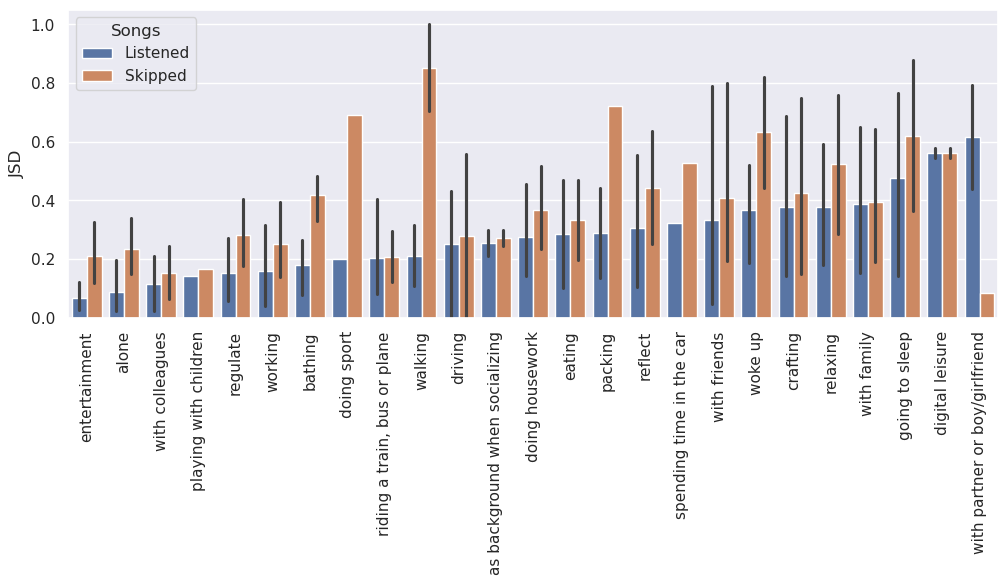

In [39]:
data['Songs'] = data['metric']
#data = data[data['Songs'] == 'Listened']

ax = sns.barplot(data.sort_values(by=['mean']), y='value', x='context', hue='Songs')
plt.xlabel("")#'I would contribute information about my current intent\n(e.g. selecting a tag or enter a short text),\nif it would result in receiving\nbetter-tailored music recommendations.')
plt.ylabel("JSD")
fig = ax.get_figure()
plt.xticks(rotation=90)

#plt.xticks(rotation=90)
fig.savefig("img/jsd_to_context.png", bbox_inches='tight') 

## Corrleation of Personality to User Behavior

In [55]:
df_sessions_user = df_valid.drop_duplicates(subset=['user_id'])

In [56]:
for g in ['user_extraversion',
 'user_agreeableness',
 'user_conscientiousness',
 'user_emotionalstability',
 'user_openness',]:
        for to_explore in ['user_skip_rate',
  'user_genre_entropy', 
  'user_mean_session_entropy']:
            groups = {}
            c = 0
            for a, v in zip(df_sessions_user[g], df_sessions_user[to_explore]):
                if a not in groups:
                    groups[a] = []
                groups[a].append(v)
            
            min_groups = {}
            
            for k, v in groups.items():
                if len(v) >= 1:
                    min_groups[k] = v
                    c += len(v)
        
            if to_explore == "user_skip_rate":
                print(g, end= " & ")
    
            print("${:.3f}".format(pearsonr(df_sessions_user[to_explore], df_sessions_user[g]).statistic), end="")
    
            groups = list(min_groups.values())
            if len(groups) == 13:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10], groups[11], groups[12]).pvalue
            elif len(groups) == 8:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7]).pvalue
            elif len(groups) == 3:
                p = kruskal(groups[0], groups[1], groups[2]).pvalue
            elif len(groups) == 7:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6]).pvalue
            elif len(groups) == 4:
                p = kruskal(groups[0], groups[1], groups[2], groups[3]).pvalue
            elif len(groups) == 2:
                p = kruskal(groups[0], groups[1]).pvalue
            elif len(groups) == 12:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10], groups[11]).pvalue
            elif len(groups) == 14:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10], groups[11], groups[12], groups[13]).pvalue
            elif len(groups) == 10:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9]).pvalue
            elif len(groups) == 11:
                p = kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7], groups[8], groups[9], groups[10]).pvalue
            
            if p < 0.01:
                print("$**", end=" & ")
            elif p < 0.05:
                print("$*", end=" & ")
            else:
                print("$", end=" & " )
        print()

user_extraversion & $0.054$ & $-0.018$ & $0.014$ & 
user_agreeableness & $-0.192$ & $0.234$ & $0.292$ & 
user_conscientiousness & $0.018$ & $-0.170$ & $-0.007$ & 
user_emotionalstability & $-0.013$ & $0.196$ & $0.259$ & 
user_openness & $0.296$ & $0.197$ & $-0.069$ & 
